## Cross Validation with sklearn functions

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
sns.set()

### Quick exploratory data analysis
The objective of this notebooke is mainly to test the CV functions

In [108]:
data = pd.read_csv('data/train.csv')   # modify path if needed
data = data.drop('state', axis=1)  # drop 'state' for simplicity
data.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [109]:
# Check missing values
data.isnull().sum().any()

False

In [110]:
data.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [111]:
# Define target variable (churn) and other binary variables as 0-1
data = data.replace({'churn': {'yes': 1, 'no': 0}, 
                    'international_plan': {'yes': 1, 'no': 0}, 
                    'voice_mail_plan': {'yes': 1, 'no': 0}})

# Define area_code dummy
data = pd.get_dummies(data, columns = ['area_code'])

data.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,0,0,1,0
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,0,0,1,0
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,0,1,0,0
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,0,0,1,0
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,...,118,9.57,7.5,7,2.03,3,0,0,0,1


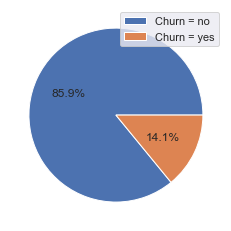

In [112]:
# Plot target variable --> we have an imbalanced class
plt.pie(data["churn"].value_counts(), autopct = '%.1f%%')
plt.legend(["Churn = no", "Churn = yes"]);

In [113]:
# Split to create a final evaluation set
X_train, X_test, y_train, y_test = train_test_split(data.drop("churn", axis=1), data["churn"], test_size=0.2, random_state=123)

# Scale the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))  # store in dataframe for stratified kfold later
X_test = pd.DataFrame(scaler.transform(X_test))

# Cross validation (example only on Logistic Regression)
lr = LogisticRegression()
cvs_all = cross_validate(lr, X=X_train, y=y_train, cv=10, scoring=['accuracy'])
cvs = cvs_all['test_accuracy']
print(cvs)
print(f"Average Accuracy score: {round(np.mean(cvs), 2)}")


[0.86470588 0.85294118 0.87058824 0.83823529 0.85882353 0.85294118
 0.85882353 0.86470588 0.87941176 0.86764706]
Average Accuracy score: 0.86


In [114]:
# Handle imbalanced dataset (stratified kfoldCV = the folds are made by preserving the percentage of samples for each class)
skf = StratifiedKFold(n_splits=10)

scores = []
for train_index, test_index in skf.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_train_cv, Y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    lr = LogisticRegression()
    lr.fit(X_train_cv, Y_train_cv)
    sc = lr.score(X_test_cv, Y_test_cv)
    print(f"Stratified kfoldVC score: {round(sc, 3)}")
    scores.append(sc)

print(f"Average Accuracy score: {round(np.mean(cvs), 2)}")

Stratified kfoldVC score: 0.865
Stratified kfoldVC score: 0.853
Stratified kfoldVC score: 0.871
Stratified kfoldVC score: 0.838
Stratified kfoldVC score: 0.859
Stratified kfoldVC score: 0.853
Stratified kfoldVC score: 0.859
Stratified kfoldVC score: 0.865
Stratified kfoldVC score: 0.879
Stratified kfoldVC score: 0.868
Average Accuracy score: 0.86


In [115]:
# Accuracy on the final evaluation set (assuming we selected Log Reg as the best model during model selection phase...)
lr = LogisticRegression().fit(X_train, y_train)
final_acc = lr.score(X_test, y_test)
print(round(final_acc, 3))

0.891


## Exercises
1) Write __my_cross_validation_score__ function
2) Perform Cross-validation (model selection) + Hold out (model evaluation) to select and evaluate the best model between a selection of classifiers

In [122]:
def my_train_test_split(df, target_col=None, random_shuffle=True, train_size=0.8, random_state=True, separated=True):
    """
    Split a dataframe in train and test sets
    PARAMETERS: 
    - df = pandas dataframes with X and y
    - target_col = string, name of the y column
    - random_shuffle = boolean, (default True), if True shuffle the dataset before splitting (False can be used for example for autocorrelated data)
    - train_size = float, percentage of datapoints to be used as train set
    - random_state = boolean, (default True), if True the results are fixed for each re-run, random otherwise
    - separated = boolean, (default True), if True the function returns X_train, X_test, y_train, y_test, otherwise it returns train, test
    OUTPUT: X_train, X_test, y_train, y_test or train, test
    """
    n = int(len(df)*train_size)
    if random_shuffle == True: 
        if random_state == True: df_s = df.sample(frac=1, random_state=123).reset_index(drop=True)
        else: df_s = df.sample(frac=1).reset_index(drop=True)
    else: df_s = df
    if separated == True:
        X_train = pd.DataFrame(df_s.drop(target_col, axis=1).loc[:n, :])
        y_train = pd.DataFrame(df_s.loc[:n, target_col])
        X_test = pd.DataFrame(df_s.drop(target_col, axis=1).loc[n+1:, :])
        y_test = pd.DataFrame(df_s.loc[n+1:, target_col])
        return X_train, X_test, y_train, y_test
    else:
        train = pd.DataFrame(df_s.loc[:n, :])
        test = pd.DataFrame(df_s.loc[n+1:, :])
        return train, test

In [123]:
X_train, X_test, y_train, y_test = my_train_test_split(data, "churn")

In [124]:
print(len(data))
print(len(X_train)+len(X_test))  # ok, same lenght as original df

4250
4250


In [125]:
def split_df_nblocks(df, n_blocks=5):
    """
    Split a dataframe into n separate blocks, no random shuffle
    PARAMETERS:
    - df = pandas dataframe
    - n_blocks = number of sub-dataframes wanted
    OUTPUT: list of sub-dataframes
    """
    block_len = int(len(df)/n_blocks)
    blocks = [df[(i*block_len):((i+1)*(block_len))][:] for i in range(n_blocks)]
    return blocks # list of df, few datapoints might get lost

df1, df2, df3 = [split_df_nblocks(data, n_blocks=3)[i] for i in range(3)]   #ok

In [126]:
def my_cross_validation_score(model, df, target_col=None, k=5, eval_score="accuracy", random_state=True, debug=False):
    """
    Compute cross validations score for each block and final score, std dev of scores (unable to handle umbalanced datasets as in this case, 'stratified' option could be added)
    PARAMETERS:
    - model = sklearn model object (for example KNeighborsClassifier())
    - df = pandas dataframe with both X and y variables to be used in the model
    - target_col = string, column name to identify y column (class to predict)
    - k = int, number of cross validation blocks
    - eval_score = string, performance metric used to evaluate the model, options are "accuracy" or "auc"
    - random_state = bool, if True the results don't change after re-run
    - debug = bool, if True print some info
    OUTPUT: average score (float), standard deviation of scores (float), list of score for each block
    """
    if random_state == True: df_s = df.sample(frac=1, random_state=123)
    else: df_s = df.sample(frac=1)
    list_blocks = split_df_nblocks(df_s, n_blocks=k)
    if debug == True:
        print(f"Number of blocks created: {len(list_blocks)}")
        print(f"Lenght of the first block: {len(list_blocks[0])}")
        print(f"Lenght of the last block: {len(list_blocks[-1])}")
        print(f"Datapoints lost: {(len(df)-len(list_blocks[0])*k)}")
    cv_scores = []
    for i, block in enumerate(list_blocks):
        if debug == True: print(f"Test set is block number {i+1}")
        # select all df in the list expect one and concatenate them to get training dataset
        train = pd.concat([bl for j, bl in enumerate(list_blocks) if j != i])
        if debug == True: print(f"Lenght of training set: {len(train)}")
        X_tr = train.drop(target_col, axis=1)
        y_tr = train[target_col]
        # use selected dataframe (block) as test set
        X_test = block.drop(target_col, axis=1)
        y_test = block[target_col]
        model.fit(X_tr, y_tr)
        if eval_score == "accuracy": 
            y_pred = model.predict(X_test)
            sc = accuracy_score(y_test, y_pred)
            cv_scores.append(sc)
        elif eval_score == "auc": 
            probs = model.predict_proba(X_test) 
            probs1 = [j for i, j in probs]
            fpr, tpr, _ = roc_curve(y_test, probs1)
            sc = auc(fpr, tpr)
            cv_scores.append(sc)
        # can add other performance metrics
    avg_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    return avg_score, std_score, cv_scores

In [127]:
# Split
data_train, data_test = my_train_test_split(data, separated=False)

# Scale the data and put everything together (no impact on dummies)
scaler = MinMaxScaler()
data_train_sc = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns) 
data_test_sc = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns)
data_train_sc.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,0.500000,0.0,1.0,0.423077,0.581792,0.5750,0.581827,0.388533,0.711765,0.388671,...,0.588571,0.519415,0.436548,0.263158,0.436090,0.222222,0.0,0.0,0.0,1.0
1,0.458678,1.0,1.0,0.307692,0.569844,0.4500,0.569779,0.550515,0.535294,0.550426,...,0.525714,0.382667,0.527919,0.157895,0.528195,0.111111,0.0,0.0,1.0,0.0
2,0.297521,0.0,0.0,0.000000,0.638407,0.5625,0.638387,0.443919,0.517647,0.444008,...,0.422857,0.488464,0.659898,0.105263,0.659774,0.111111,0.0,0.0,1.0,0.0
3,0.475207,0.0,1.0,0.461538,0.522333,0.8625,0.522256,0.567214,0.529412,0.567125,...,0.508571,0.422622,0.304569,0.157895,0.304511,0.222222,0.0,1.0,0.0,0.0
4,0.471074,0.0,0.0,0.000000,0.756472,0.7000,0.756359,0.369886,0.552941,0.370007,...,0.605714,0.468768,0.741117,0.368421,0.740602,0.111111,0.0,0.0,1.0,0.0


In [128]:
# Check if the function is working correctly
knn = KNeighborsClassifier(n_neighbors=5)
_, _, _ = my_cross_validation_score(knn, data_train_sc, target_col="churn", k=4, debug=True)  # use only training set

# Ok number of blocks, ok lenght is the same for each one, 
# Ok in the loop each time all the remaining blocks are combined to create the training set 

Number of blocks created: 4
Lenght of the first block: 850
Lenght of the last block: 850
Datapoints lost: 1
Test set is block number 1
Lenght of training set: 2550
Test set is block number 2
Lenght of training set: 2550
Test set is block number 3
Lenght of training set: 2550
Test set is block number 4
Lenght of training set: 2550


In [129]:
# Function output
avg_score, std_score, list_scores = my_cross_validation_score(knn, data_train_sc, target_col="churn", k=4)
print(list_scores)
print(round(avg_score, 3))

[0.9035294117647059, 0.8964705882352941, 0.8941176470588236, 0.8964705882352941]
0.898


In [144]:
def models_selection_evaluation(dict_models, trtestcv, final_test, target_col=None, k=5, eval_score="accuracy", eval_all=False, random_state=True, debug=False):
    """
    Perform cross-validation for all the models passed, select the best performer and test it on a final evaluation set. 
    PARAMETERS:
    - dict_models = dictionary, all the models to test (for example dict_model = {"KNN": KNeighborsClassifier(), "Logreg": LogisticRegression()}) 
    - trtestcv = dataframe to be used in the cross-validation process
    - final_test = dataframe to be used in the final evaluation process
    - eval_all = bool, if True add to the final dataframe the performance on the final evaluation set for all the models
    - target_col, k, eval_score, random_state, debug ===> same as the function 'my_cross_validation_score'
    OUTPUT: score for the best performer, pandas dataframe with results of model selection
    """
    # 1) Define final evaluation set
    if debug == True: print(f"Lenght of final evaluation set: {len(final_test)}")
    X_finaltest = final_test.drop(target_col, axis=1)
    y_finaltest = final_test[target_col]
    # 2) perform kfoldCV for each model in the dictionary
    cv_eval_results = pd.DataFrame(index = list(dict_models.keys()), columns=[f"Block {i+1}" for i in range(k)])
    for name, mod in dict_models.items():
        # pass only the df part selected to be used in the CV process (trtestcv)
        avg_sc, stdev_sc, list_scores = my_cross_validation_score(mod, df=trtestcv, target_col=target_col, k=k, eval_score=eval_score, random_state=random_state)
        # list(dict_models.keys()).index(name) used to avoid warning future error with loc
        cv_eval_results.iloc[list(dict_models.keys()).index(name), :k] = list_scores
        cv_eval_results.loc[name, "Average_Score"] = avg_sc
        cv_eval_results.loc[name, "StdDev_Score"] = stdev_sc
        if debug == True: print(f"Evaluating {name} --> kfoldCV score = {round(avg_sc, 3)}")
        # 2.1) Compute performance on final_test set for all models if parameter is True
        mod.fit(trtestcv.drop(target_col, axis=1), trtestcv[target_col])
        if eval_all == True:
            if eval_score == "accuracy": 
                final_score = mod.score(X_finaltest, y_finaltest)
                cv_eval_results.loc[name, "Score_final_evaluation"] = final_score
                if debug == True: print(f"Computing score on final evaluation set for {name} --> score = {final_score}")
            elif eval_score == "auc": 
                probs = mod.predict_proba(X_finaltest) 
                probs1 = [j for i, j in probs]
                fpr, tpr, _ = roc_curve(y_finaltest, probs1)
                final_score = auc(fpr, tpr)
                cv_eval_results.loc[name, "Score_final_evaluation"] = final_score
                if debug == True: print(f"Computing score on final evaluation set (len = {len(X_finaltest)}) for {name} --> score = {final_score}")
    # 3) Select best performer and evaluate it on the final evaluation set
    best_model = cv_eval_results["Average_Score"].idxmax()
    if debug == True: print(f"The best model is {best_model}")
    mod = dict_models[best_model]
    # use the entire dataset used for kfoldCV as training set
    mod.fit(trtestcv.drop(target_col, axis=1), trtestcv[target_col])
    if eval_score == "accuracy": 
        final_score_best = mod.score(X_finaltest, y_finaltest)
    elif eval_score == "auc": 
        probs = mod.predict_proba(X_finaltest) 
        probs1 = [j for i, j in probs]
        fpr, tpr, _ = roc_curve(y_finaltest, probs1)
        final_score_best = auc(fpr, tpr)
    return cv_eval_results, best_model, final_score_best


In [146]:
# Test the function
models = {"kNN_5": KNeighborsClassifier(n_neighbors=5), 
        "kNN_20": KNeighborsClassifier(n_neighbors=20), 
        "LogReg": LogisticRegression()}

df_sel, best, final_sc_best = models_selection_evaluation(dict_models=models,  # all models to be tested
                                                        trtestcv=data_train_sc, final_test=data_train_sc,  # datasets
                                                        target_col="churn", k=3, eval_all = True,
                                                        debug=True, )
# test seems ok

Lenght of final evaluation set: 3401
Evaluating kNN_5 --> kfoldCV score = 0.894
Computing score on final evaluation set for kNN_5 --> score = 0.9241399588356366
Evaluating kNN_20 --> kfoldCV score = 0.874
Computing score on final evaluation set for kNN_20 --> score = 0.8853278447515437
Evaluating LogReg --> kfoldCV score = 0.867
Computing score on final evaluation set for LogReg --> score = 0.8688620993825346
The best model is kNN_5


In [147]:
# Dataframe with the Cross Validation model selection results 
df_sel

,Block 1,Block 2,Block 3,Average_Score,StdDev_Score,Score_final_evaluation
kNN_5,0.8985,0.894086,0.888791,0.893792,0.003969,0.924140
kNN_20,0.88173,0.872021,0.868491,0.874081,0.005598,0.885328
LogReg,0.871139,0.866726,0.863195,0.867020,0.003250,0.868862


In [148]:
# Best performing model and its score on the final evaluation set
best, round(final_sc_best, 3)

('kNN_5', 0.924)